In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from src.FeatureSelector import FeatureSelector
from DataGenerator import generate_data, get_one_hot
from IPython.display import display
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('../data_preprocessed.csv')
df.head()

,caseid,age,sex,bmi,asa,emop,anedur,los_postop,los_icu,death_inhosp,preop_htn,preop_dm,preop_arrhythmia,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,intraop_epi,intraop_ca,WBC,Hb,PLT,Albumin,GOT (AST),GPT (ALT),Creatinine,Sodium,Potassium,Chloride,hs-CRP quantitation,PT (INR),aPTT,Fibrinogen,pH,pCO₂,pO₂,HCO3-,BE,Calcium,Glucose,Lactic acid,mean_HR,std_HR,mean_BT1,std_BT1,mean_PLETH_SPO2,std_PLETH_SPO2,mean_FIO2,std_FIO2,mean_ST_II,std_ST_II,mean_ETCO2,std_ETCO2,mean_ART_SBP,std_ART_SBP,mean_NIBP_SBP,std_NIBP_SBP,mean_NIBP_DBP,std_NIBP_DBP,mean_ART_DBP,std_ART_DBP,mean_NIBP_MBP,std_NIBP_MBP,mean_ART_MBP,std_ART_MBP,mean_DBP,std_DBP,mean_SBP,std_SBP,mean_MBP,std_MBP
0,1,77.0,1,26.3,2.0,0,180,8,0,0,1,0,0,0,14.1,189.0,94.0,33.2,141.0,3.1,134.0,4.3,18.0,16.0,10.0,0.82,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.0,3.1,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81.485556,2.996626,36.116111,0.093483,99.055556,0.757038,47.153333,11.716376,-0.519222,0.092866,33.675556,0.678005,116.444444,19.841312,NaN,NaN,NaN,NaN,51.573333,9.962676,NaN,NaN,75.945556,13.616238,51.573333,9.962676,116.444444,19.841312,75.945556,13.616238
1,2,54.0,1,19.6,2.0,0,245,19,0,0,0,0,0,0,10.2,251.0,110.0,31.9,143.0,4.7,88.0,3.8,18.0,15.0,14.0,0.86,0,0,4.36,10.2,251.0,NaN,NaN,NaN,NaN,143.0,4.7,115.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79.102336,1.852761,35.730145,0.045914,100.000000,0.000000,38.688543,13.763545,NaN,NaN,36.868743,2.527469,NaN,NaN,103.014461,4.396903,65.304783,2.581088,NaN,NaN,76.676307,3.967126,NaN,NaN,65.304783,2.581088,103.014461,4.396903,76.676307,3.967126
2,3,62.0,1,24.4,1.0,0,65,2,0,0,0,0,0,0,14.2,373.0,103.0,30.3,144.0,4.9,87.0,4.2,17.0,34.0,14.0,1.18,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.496940,7.881960,35.472559,0.057151,99.414663,1.648374,58.315927,28.819101,0.954182,0.183815,34.464752,2.591728,-0.857143,0.363137,107.215422,7.365301,63.503060,5.052693,-0.857143,0.363137,80.075887,4.701024,-0.857143,0.363137,-0.857143,0.363137,-0.857143,0.363137,-0.857143,0.363137
3,4,74.0,1,20.5,2.0,0,335,7,1,0,1,0,0,0,14.4,275.0,103.0,34.5,141.0,4.2,108.0,4.1,23.0,18.0,10.0,0.96,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,144.0,4.3,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.750562,6.536445,35.349480,0.050034,100.000000,0.000000,48.066292,24.410602,-0.586573,0.193934,30.343820,4.832957,111.813483,20.446562,NaN,NaN,NaN,NaN,51.089888,6.517331,NaN,NaN,70.892135,10.227758,51.089888,6.517331,111.813483,20.446562,70.892135,10.227758
4,5,66.0,1,20.4,3.0,1,350,45,13,0,1,0,1,0,10.1,67.0,73.0,36.5,146.0,4.4,126.0,2.6,765.0,77.0,50.0,4.43,0,2100,14.64,15.3,158.0,4.6,64.0,30.0,1.83,139.0,4.9,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.9,140.0,NaN,83.275785,3.881121,29.771968,0.225909,99.790850,0.717713,83.005282,5.320253,0.318468,0.223069,39.570423,2.281427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
"""
df = df[['age', 'sex', 'bmi', 'emop', 'death_inhosp', 'preop_htn', 'preop_dm', 'preop_arrhythmia',
       'preop_pft', 'preop_hb', 'preop_plt', 'preop_pt', 'preop_aptt',
       'preop_na', 'preop_k', 'preop_glucose', 'preop_alb', 'preop_got',
       'preop_gpt', 'preop_bun', 'preop_cr']].reset_index(drop=True).copy()
"""
df_death = df[(df['death_inhosp'] == 1) & (df['los_postop'] <= 30)]
df_surv = df[(df['death_inhosp'] != 1)]
df = pd.merge(df_death, df_surv, how='outer')

#df['preop_pft'] = np.where(df['preop_pft'].str.contains('N', regex=True), 0, 1)
df.head()

,caseid,age,sex,bmi,asa,emop,anedur,los_postop,los_icu,death_inhosp,preop_htn,preop_dm,preop_arrhythmia,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,intraop_epi,intraop_ca,WBC,Hb,PLT,Albumin,GOT (AST),GPT (ALT),Creatinine,Sodium,Potassium,Chloride,hs-CRP quantitation,PT (INR),aPTT,Fibrinogen,pH,pCO₂,pO₂,HCO3-,BE,Calcium,Glucose,Lactic acid,mean_HR,std_HR,mean_BT1,std_BT1,mean_PLETH_SPO2,std_PLETH_SPO2,mean_FIO2,std_FIO2,mean_ST_II,std_ST_II,mean_ETCO2,std_ETCO2,mean_ART_SBP,std_ART_SBP,mean_NIBP_SBP,std_NIBP_SBP,mean_NIBP_DBP,std_NIBP_DBP,mean_ART_DBP,std_ART_DBP,mean_NIBP_MBP,std_NIBP_MBP,mean_ART_MBP,std_ART_MBP,mean_DBP,std_DBP,mean_SBP,std_SBP,mean_MBP,std_MBP
0,59,74.0,1,28.8,3.0,0,40,1,0,1,0,0,0,0,11.2,104.0,91.0,32.9,141.0,4.0,141.0,4.1,25.0,20.0,18.0,1.11,0,0,NaN,NaN,NaN,4.1,25.0,20.0,NaN,NaN,NaN,NaN,NaN,1.06,32.9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.569705,8.534877,NaN,NaN,96.576380,2.552836,35.772926,0.902359,-0.739459,0.235172,38.160116,2.368521,104.875628,47.343608,72.000000,0.000000,43.000000,0.000000,51.261307,33.683127,55.000000,0.000000,67.579853,40.713294,51.261307,33.683127,104.875628,47.343608,67.579853,40.713294
1,86,76.0,1,22.8,2.0,0,80,4,0,1,0,0,0,0,11.8,289.0,75.0,25.7,135.0,4.5,164.0,3.2,10.0,15.0,13.0,0.74,0,0,21.35,11.8,289.0,3.2,10.0,15.0,0.74,135.0,4.5,102.0,NaN,1.22,25.7,508.0,NaN,NaN,NaN,NaN,NaN,10.4,164.0,NaN,89.501188,2.268142,NaN,NaN,99.392512,2.158595,NaN,NaN,0.589030,0.106441,NaN,NaN,NaN,NaN,105.429124,6.188032,50.877577,2.798933,NaN,NaN,67.975515,2.911276,NaN,NaN,50.877577,2.798933,105.429124,6.188032,67.975515,2.911276
2,94,73.0,1,26.4,2.0,0,470,25,1,1,0,1,0,0,13.9,85.0,88.0,34.2,NaN,NaN,88.0,4.2,32.0,19.0,19.0,0.87,0,450,3.71,12.2,81.0,4.2,32.0,19.0,0.87,135.0,4.5,99.0,0.04,1.09,34.2,276.0,NaN,NaN,NaN,NaN,NaN,9.0,88.0,NaN,70.746584,7.373671,NaN,NaN,99.762608,0.640566,41.428571,3.408738,0.094226,0.109325,35.996860,1.232420,101.329837,38.862647,114.000000,0.000000,54.000000,0.000000,56.083818,28.684888,72.000000,0.000000,72.292135,40.237988,56.083818,28.684888,101.329837,38.862647,72.292135,40.237988
3,95,70.0,1,16.1,3.0,0,65,6,0,1,0,0,0,1,9.5,265.0,69.0,31.8,131.0,4.4,145.0,2.8,48.0,83.0,18.0,0.57,0,0,8.05,7.9,305.0,2.8,84.0,98.0,0.54,131.0,4.3,98.0,7.79,1.43,29.9,486.0,NaN,NaN,NaN,NaN,NaN,8.0,145.0,NaN,90.788360,7.794694,29.650391,7.204035,99.803636,1.549424,45.488889,22.026256,NaN,NaN,27.281046,1.361674,NaN,NaN,118.451415,14.516567,82.068881,8.061658,NaN,NaN,95.618696,11.343592,NaN,NaN,82.068881,8.061658,118.451415,14.516567,95.618696,11.343592
4,124,46.0,0,19.9,2.0,1,145,7,0,1,0,0,0,0,11.6,216.0,100.0,31.5,141.0,4.0,81.0,4.4,15.0,10.0,12.0,0.63,0,0,3.51,9.3,184.0,4.4,42.0,40.0,0.63,140.0,4.3,103.0,0.03,0.96,29.3,251.0,NaN,NaN,NaN,NaN,NaN,9.3,126.0,NaN,67.254749,5.847418,36.162039,0.054061,99.426009,1.761324,45.723329,19.889740,0.140389,0.206581,37.773740,1.092727,111.646720,10.537542,99.000000,0.000000,61.000000,0.000000,67.695052,5.935540,83.000000,0.000000,90.454444,27.802640,67.695052,5.935540,111.646720,10.537542,90.454444,27.802640


In [4]:
pd.DataFrame(df.isnull().sum() / len(df), columns=['Null Percentage']).T

,caseid,age,sex,bmi,asa,emop,anedur,los_postop,los_icu,death_inhosp,preop_htn,preop_dm,preop_arrhythmia,preop_pft,preop_hb,preop_plt,preop_pt,preop_aptt,preop_na,preop_k,preop_glucose,preop_alb,preop_got,preop_gpt,preop_bun,preop_cr,intraop_epi,intraop_ca,WBC,Hb,PLT,Albumin,GOT (AST),GPT (ALT),Creatinine,Sodium,Potassium,Chloride,hs-CRP quantitation,PT (INR),aPTT,Fibrinogen,pH,pCO₂,pO₂,HCO3-,BE,Calcium,Glucose,Lactic acid,mean_HR,std_HR,mean_BT1,std_BT1,mean_PLETH_SPO2,std_PLETH_SPO2,mean_FIO2,std_FIO2,mean_ST_II,std_ST_II,mean_ETCO2,std_ETCO2,mean_ART_SBP,std_ART_SBP,mean_NIBP_SBP,std_NIBP_SBP,mean_NIBP_DBP,std_NIBP_DBP,mean_ART_DBP,std_ART_DBP,mean_NIBP_MBP,std_NIBP_MBP,mean_ART_MBP,std_ART_MBP,mean_DBP,std_DBP,mean_SBP,std_SBP,mean_MBP,std_MBP
Null Percentage,0.0,0.0,0.0,0.0,0.020863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05358,0.053264,0.061324,0.062905,0.097993,0.097677,0.059586,0.058638,0.057373,0.057373,0.057373,0.05848,0.0,0.0,0.333491,0.333491,0.336652,0.344713,0.344397,0.344397,0.352458,0.241821,0.242137,0.242611,0.514936,0.39529,0.396554,0.429429,0.942153,0.942153,0.942153,0.942153,0.982772,0.314683,0.403351,0.942311,0.002213,0.002213,0.114588,0.114746,0.002371,0.002371,0.031294,0.031611,0.072862,0.072862,0.030504,0.031294,0.451241,0.451399,0.319109,0.319583,0.319109,0.319583,0.451399,0.451557,0.315948,0.316422,0.451557,0.451715,0.005216,0.005374,0.005216,0.005374,0.005374,0.005532


In [5]:
df.fillna(df.median(), inplace=True)

In [6]:
X = df[['age', 'sex', 'bmi', 'preop_alb', 'preop_pt', 'preop_aptt', 'preop_hb', 
          'preop_cr', 'preop_na', 'preop_plt', 'preop_got', 'preop_gpt', 'hs-CRP quantitation', 
          'preop_glucose', 'mean_HR', 'std_HR', 'mean_BT1', 'std_BT1', 'mean_PLETH_SPO2', 
          'std_PLETH_SPO2', 'mean_FIO2', 'std_FIO2', 'mean_ST_II', 'std_ST_II', 
          'mean_ETCO2', 'std_ETCO2', 'mean_DBP', 'std_DBP', 'mean_SBP', 'std_SBP', 'mean_MBP', 'std_MBP']]
feature_name = X.columns

y = df['death_inhosp']

In [7]:
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, 
                                                test_size=0.2, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_tmp, y_tmp, 
                                                test_size=0.2, stratify=y_tmp)

In [8]:
X_train.shape

(4048, 32)

In [9]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1004, sampling_strategy=0.2)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_train.shape

(1380, 32)

In [10]:
y_train.value_counts()

0    1150
1     230
Name: death_inhosp, dtype: int64

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)

In [11]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [12]:
y_train = pd.get_dummies(y_train).values
y_val = pd.get_dummies(y_val).values
y_test = pd.get_dummies(y_test).values

In [13]:
print('Train sample size: {}'.format(len(X_train)))
print('Val sample size: {}'.format(len(X_val)))
print('Test sample size: {}'.format(len(X_test)))

Train sample size: 1380
Val sample size: 1013
Test sample size: 1266


In [14]:
X_train.shape

(1380, 32)

In [15]:
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Dataset parameters
N_TRAIN_SAMPLES = 4048
N_VAL_SAMPLES = 1013
N_TEST_SAMPLES = 1266
N_FEATURES = 32
FEATURE_SHAPE = (32,)
dataset_label = "Survival"

# Training parapmeters
data_batch_size = 64
mask_batch_size = 64
# final batch_size is data_batch_size x mask_batch_size
s = 6  # size of optimal subset that we are looking for
s_p = 3  # number of flipped bits in a mask when looking around m_opt
phase_2_start = 6000  # after how many batches phase 2 will begin
max_batches = 10000  # how many batches if the early stopping condition not satisfied
early_stopping_patience = 600  # how many patience batches (after phase 2 starts)
# before the training stops

In [16]:

# Generate data for XOR dataset:
# First three features are used to create the target (y)
# All the following features are gaussian noise
# In total 10 features
#X_tr, y_tr = generate_data(n=N_TRAIN_SAMPLES, seed=0)
#X_val, y_val = generate_data(n=N_VAL_SAMPLES, seed=0)
#X_te, y_te = generate_data(n=N_TEST_SAMPLES, seed=0)

# Get one hot encoding of the labels
#y_tr = get_one_hot(y_tr.astype(np.int8), 4)
#y_te = get_one_hot(y_te.astype(np.int8), 4)
#y_val = get_one_hot(y_val.astype(np.int8), 4)

# Create the framework, needs number of features and batch_sizes, str_id for tensorboard
fs = FeatureSelector(FEATURE_SHAPE, s, data_batch_size, mask_batch_size, str_id=dataset_label)

# Create a dense operator net, uses the architecture:
# N_FEATURES x 2 -> 60 -> 30 -> 20 -> 4
# with sigmoid activation in the final layer.
fs.create_dense_operator([300, 300, 200, 2], "softmax", metrics=[keras.metrics.CategoricalAccuracy()],
                       error_func=K.categorical_crossentropy)
# Ealy stopping activate after the phase2 of the training starts.
fs.operator.set_early_stopping_params(phase_2_start, patience_batches=early_stopping_patience, minimize=True)

# Create a dense selector net, uses the architecture:
# N_FEATURES -> 60 -> 30 -> 20 -> 4
fs.create_dense_selector([300, 100, 30, 1])

# Set when the phase2 starts, what is the number of flipped bits when perturbin masks
fs.create_mask_optimizer(epoch_condition=phase_2_start, perturbation_size=s_p)

#Train networks and set the maximum number of iterations
fs.train_networks_on_data(X_train, y_train, max_batches, val_data=(X_val, y_val))

#Results
importances, optimal_mask = fs.get_importances(return_chosen_features=True)
optimal_subset = np.nonzero(optimal_mask)
test_performance = fs.operator.test_one(X_test, optimal_mask[None,:], y_test)
print("Importances: ", importances)
print("Optimal_subset: ", optimal_subset)
print("Test performance (CE): ", test_performance[0])
print("Test performance (ACC): ", test_performance[1])

Creating operator model
Object network model built:
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32)           0           input_1[0][0]                    
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 32)           0           input_2[0][0]                    
__________________________________________

In [17]:
result = pd.DataFrame({'feature': feature_name, 'importance':importances})
result.head()

,feature,importance
0,age,0.005470
1,sex,0.000794
2,bmi,0.000650
3,preop_alb,0.025038
4,preop_pt,0.008325


In [18]:
feature_name[optimal_subset[0]]

Index(['age', 'preop_alb', 'preop_pt', 'preop_hb', 'preop_na',
       'hs-CRP quantitation'],
      dtype='object')

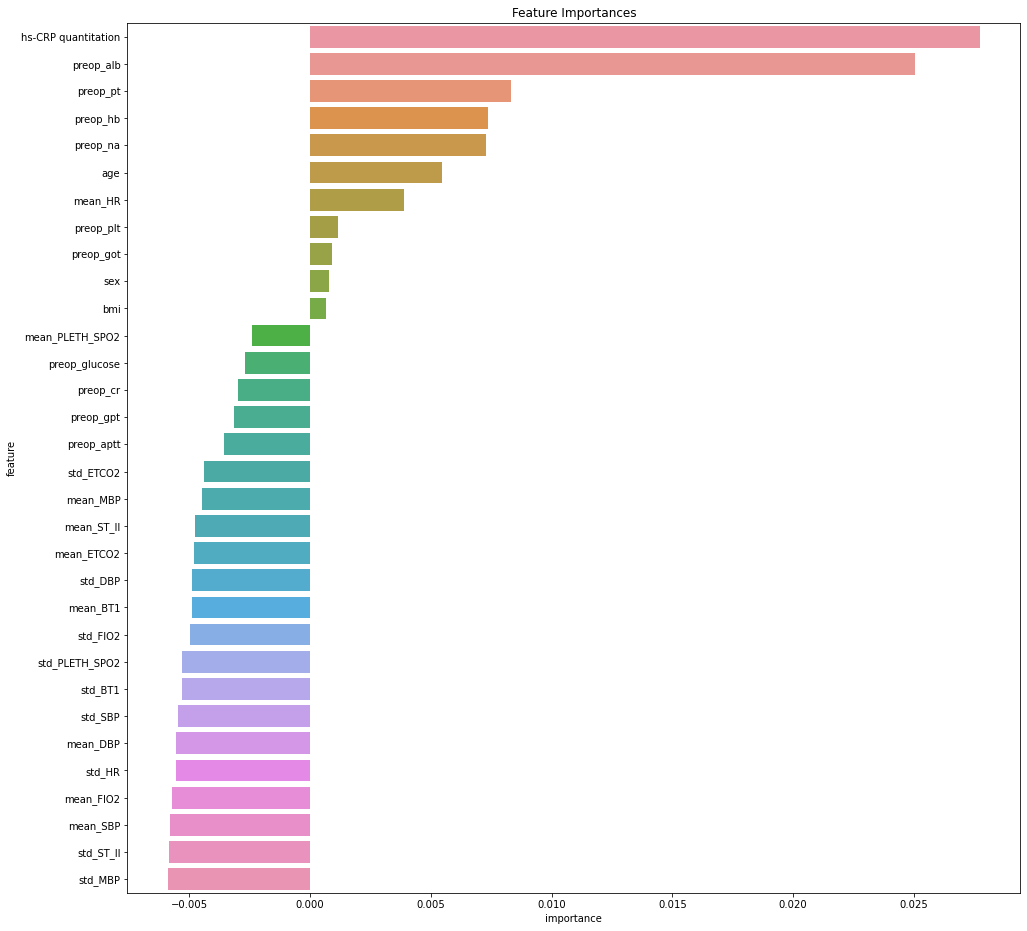

In [19]:
import seaborn as sns
plt.figure(figsize=(16, 16))
plt.xticks()
sns.barplot(data=result.sort_values(by='importance', ascending=False), x='importance', y='feature')
plt.title('Feature Importances')
plt.show()

In [20]:
fs.operator.test_one(X_test, optimal_mask[None,:], y_test)

[0.27858608961105347, 0.9036334753036499, 0.0]

In [21]:
_, _, y_prim, y_prob = fs.operator.validate_one(X_test, optimal_mask[None,:], y_test)

In [22]:
X[X['mean_ETCO2'] < 10]['mean_ETCO2']

355     0.000000
1359    0.004489
1613    1.616216
1894    2.000000
1960    0.000000
2302    8.750000
2551    0.162679
2829    1.000000
3326    8.000000
3990    0.000000
4061    0.000000
4207    5.423601
4562    1.169811
4717    7.000000
4860    0.000000
5507    0.000000
5686    9.933495
5797    0.000000
6269    0.286501
Name: mean_ETCO2, dtype: float64